In [1]:
from osgeo import gdal
from osgeo import osr
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

plt.style.use('default')

In [2]:
@jit(nopython=True)
def get_window(dem_array, x, y):
    '''This function returns the eight neighbors for the current pixel xy (e)'''
    a = dem_array[x-1][y+1]
    b = dem_array[x][y+1];
    c = dem_array[x+1][y+1];
    d = dem_array[x-1][y];
    f = dem_array[x+1][y];
    g = dem_array[x-1][y-1];
    h = dem_array[x][y-1];
    i = dem_array[x+1][y-1];
    return [a,b,c,d,f,g,h,i]

In [3]:
@jit(nopython=True)
def horne(nb8, cx, cy):
    '''Numba function for Horn algorithm'''
    # Get a, b, c, d, f, g, h, i from neighbors list
    a = nb8[0]
    b = nb8[1]
    c = nb8[2]
    d = nb8[3]
    f = nb8[4]
    g = nb8[5]
    h = nb8[6]
    i = nb8[7]
    
    # The rate of change in the x direction for cell e
    dzdx =  ((c + 2.0*f + i) - (a + 2.0*d + g))/(8.0 * cx);
    
    # The rate of change in the y direction for cell e
    dzdy = ((g + 2.0*h + i) - (a + 2.0*b + c))/(8.0 * cy);
    return [dzdx, dzdy]

In [4]:
@jit(nopython=True)  
def slope(dem_array, cx, cy):
    '''Function to calculate slope'''
    # Create an empty array to store the result
    out_slope = np.zeros((dem_array.shape[0], dem_array.shape[1])).astype(np.float32)
    for x in range(1, dem_array.shape[0]-1):
        for y in range(1, dem_array.shape[1]-1):
            
            # Get eight neighbors for the current xy     
            nb8 = get_window(dem_array, x, y)
            
            # The rate of change in the x,y direction for cell e
            dzdx, dzdy = horne(nb8, cx, cy)
            
            # Convert slope to degrees
            slp = np.arctan(np.sqrt(dzdx * dzdx + dzdy *dzdy)) * 180.0/np.pi
            
            # Clip slope value between 0 to 90        
            slp = 0 if slp < 0.0 else 90 if slp > 90.0 else slp
            
            # Set the central pixel (e) value 
            out_slope[x,y] = slp               
    return out_slope

In [5]:
@jit(nopython=True)
def aspect(dem_array, cx, cy):
    '''Function to calculate Aspect'''
    # Create an empty array to store the result
    out_aspect = np.zeros((dem_array.shape[0], dem_array.shape[1])).astype(np.float32)
    for x in range(1, dem_array.shape[0]-1):
        for y in range(1, dem_array.shape[1]-1):
            
            # Get eight neighbors for the current xy     
            nb8 = get_window(dem_array, x, y)
            
            # The rate of change in the x,y direction for cell e
            dzdx, dzdy = horne(nb8, cx, cy)
            
            # Convert aspect to degrees   
            aspect = np.arctan2(dzdx,dzdy) * 180/np.pi
            
            # The aspect value is then converted to compass direction values (0-360 degrees)         
            aspect = (90.0 - aspect) if aspect < 0.0 else (360.0 - aspect + 90.0) if aspect > 90.0 else (90.0 - aspect)
            
            # Clip aspect value between 0 to 360 and set flat pixels to -1         
            aspect = 0 if aspect < 0.0 else 360 if aspect > 360.0 else -1 if aspect == 90.0 else aspect 
            
            # Set the central pixel (e) value
            out_aspect[x,y] = aspect            
    return out_aspect    

In [6]:
@jit(nopython=True)
def hillshade(dem_array, azimuth, altitude, cx, cy):
    '''Numba function to calculate Hillshade'''  
    # Create an empty array to store the result
    out_hillsha = np.zeros((dem_array.shape[0], dem_array.shape[1])).astype(np.uint8)
    
    # Convert azimuth angle to radians
    azimuth_math = (360.0 - azimuth + 90.0) 
    
    if azimuth_math > 360.0:
        azimuth_math -= 360.0
        
    azimuth_rad =  azimuth_math * (np.pi / 180.0)
    
    # Convert altitude to radians
    altitude_rad = (90.0 - altitude) * (np.pi / 180.0)
    
    for x in range(1, dem_array.shape[0]-1):
        for y in range(1, dem_array.shape[1]-1):
            
            # Get eight neighbors for the current xy
            nb8 = get_window(dem_array, x, y)
            
            # The rate of change in the x,y direction for cell e
            dzdx, dzdy = horne(nb8, cx, cy)
            
            # Calculate the slope in radians
            slope = np.arctan(np.sqrt(dzdx * dzdx + dzdy * dzdy))
            
            # Calculate the aspect in radians
            aspect = np.arctan2(dzdx,dzdy)
            
            # Calculate the hillshade
            hillsha = 254 * ((np.cos(altitude_rad) * np.cos(slope)) + (np.sin(altitude_rad) * np.sin(slope) * np.cos(azimuth_rad - aspect)))         
            
            # Clip hillshade value between 1 to 254
            hillsha = 1 if hillsha < 0 else 254 if hillsha > 254 else hillsha
            
            # Set the central pixel (e) value
            out_hillsha[x,y] = hillsha
    return out_hillsha         


In [7]:
# Read the input data
input_dem = r"..\Data\N46E009.hgt"
dem_src = gdal.Open(input_dem)

# Get raster first band
dem_band = dem_src.GetRasterBand(1)

# Convert to numpy array
dem_array = dem_band.ReadAsArray().astype(float)
print(dem_array)

[[2835. 2822. 2805. ... 1135. 1129. 1121.]
 [2835. 2831. 2760. ... 1144. 1135. 1127.]
 [2816. 2757. 2740. ... 1153. 1145. 1139.]
 ...
 [ 272.  272.  272. ... 1776. 1765. 1760.]
 [ 272.  272.  272. ... 1773. 1761. 1756.]
 [ 272.  272.  272. ... 1752. 1744. 1744.]]


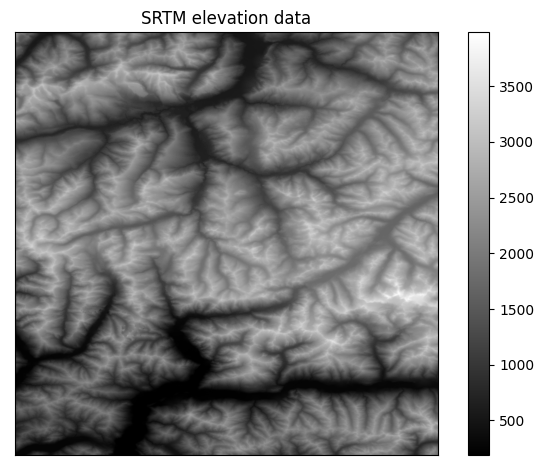

In [8]:
# Show SRTM elevation data
fig, ax = plt.subplots(1,1)
ax.set_title('SRTM elevation data')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(dem_array, cmap="gist_gray")
plt.colorbar()
plt.tight_layout()
plt.show()

In [9]:
# Get raster geotransform
gt = list(dem_src.GetGeoTransform())

# Get raster projection
prj = dem_src.GetProjection()

# Create SpatialReference from prj
srs = osr.SpatialReference(wkt=prj)

# Get the cellsize x,y
cellsize_x = gt[1]
cellsize_y = -1.0 * gt[5]      
        
# If cellsize is stored in degrees multiply cellsize_x/y by 1.11e5 to get meters
cellsize_x = cellsize_x * 1.11e5 if srs.IsGeographic() else cellsize_x
cellsize_y = cellsize_y * 1.11e5 if srs.IsGeographic() else cellsize_x

In [10]:
# Hillshade parameters
azimuth = 315
altitude = 45

output_slope = slope(dem_array, cellsize_x, cellsize_y)
output_aspect = aspect(dem_array, cellsize_x, cellsize_y)
output_hillshade = hillshade(dem_array, azimuth, altitude, cellsize_x, cellsize_y)

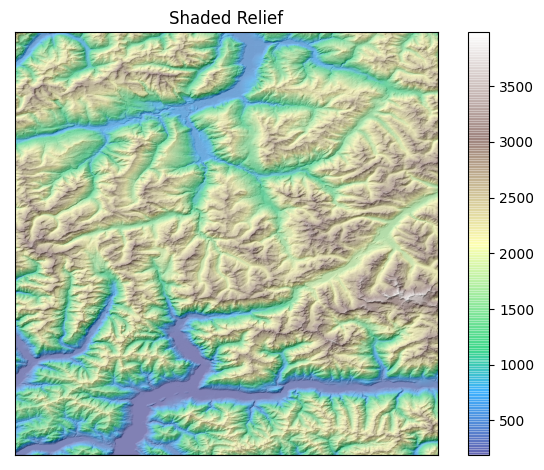

In [11]:
# Show the Shaded relief

fig, ax = plt.subplots(1,1)
ax.set_title('Shaded Relief')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(output_hillshade, cmap="Greys_r")
plt.imshow(dem_array, cmap="terrain", alpha=0.5)
plt.colorbar()
plt.tight_layout()
plt.show()

<b> Numba vs Loop </b>

%%timeit results with @jit(nopython=True) decorator:<br>
<b>Numba</b>: 4.45 s ± 63.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) 

%%timeit results without @jit(nopython=True) decorator:<br>
<b>Loop</b>: 3min 10s ± 15.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)